In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset,random_mini_batches,convert_to_one_hot,predict

np.random.seed(1)

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
 
    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels
 
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
 

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
 
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [20]:
def convert_to_one_hot(Y,C): # y是array，取的np.eye(C)的列
    return np.eye(C)[Y.reshape(-1)].T

In [29]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation(X, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def one_hot_matrix(labels,C):
    C = tf.constant(C,name = "C")
    one_hot_matrix = tf.one_hot(labels,C,1) # axis = 1
    sess = tf.Session()
    one_hot =  sess.run(one_hot_matrix).T    
    sess.close()
    return one_hot

def ones(shape):
    ones = tf.ones(shape)
    sess = tf.Session()
    ones = sess.run(ones)
    sess.close()
    return ones

def zeros(shape):
    zeros = tf.zeros(shape)
    sess = tf.Session()
    zeros = sess.run(zeros)
    sess.close()
    return zeros

def sigmoid(z):
    x = tf.placeholder(tf.float32,name = "x")
    sigmoid = tf.sigmiod(z)
    with tf.Session() as sess:
        result = sess.run(sigmoid,feed_dict = {x:z})
    return z

y =5


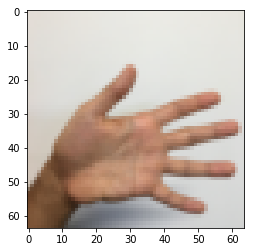

In [6]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
index = 0
plt.imshow(X_train_orig[index])
print("y ="+str(np.squeeze(Y_train_orig[:,index])))

In [7]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T
X_train = X_train_flatten/255
X_test = X_test_flatten/255
Y_train = convert_to_one_hot(Y_train_orig,6)
Y_test = convert_to_one_hot(Y_test_orig,6)

In [8]:
Y_train

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.]])

In [9]:
def create_placeholders(n_x,n_y):# none 更灵活
    X = tf.placeholder(tf.float32,[n_x,None],name = "X")
    Y = tf.placeholder(tf.float32,[n_y,None],name = 'Y')
    return X,Y
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###
 
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    return parameters


In [30]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
 
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.matmul(W1, X) + b1                                           # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.matmul(W2, A1) + b2                               # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.matmul(W3, A2) + b3                            # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [31]:
def compute_cost(z3,Y):
    # transpose to fit the tf requirement for nn.softmax_cross_entropy calculation
    logits = tf.transpose(z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = labels))
    return cost


In [32]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()# 防止重写tf变量
    tf.set_random_seed(1)
    seed = 3
    (n_x,m) = X_train.shape # X,Y并没有定义过
    n_y = Y_train.shape[0]
    costs = []
    
    X,Y = create_placeholders(n_x,n_y)
    
    parameters = initialize_parameters()
    z3 = forward_propagation(parameters,X)
    cost = compute_cost(z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for i in range(num_epochs):
            epoch_cost = 0
            seed = seed +1
            minibatches = random_mini_batches(X_train,Y_train,minibatch_size,seed)
            num_minibatches = m//minibatch_size

            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                _,minibatch_cost = sess.run([optimizer,cost],feed_dict = {X:minibatch_X,Y:minibatch_Y})
                epoch_cost += minibatch_cost/num_minibatches

            if print_cost == True and i % 100 == 0:
                print ("Cost after epoch %i: %f" % (i, epoch_cost))
            if print_cost == True and i % 5 == 0:
                costs.append(epoch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters) # save parameters?
        print("Parameters have been trained")

        correct_prediction = tf.equal(tf.argmax(z3),tf.argmax(Y)) # ???
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))

        print("train accu:", accuracy.eval({X:X_train,Y: Y_train}))
        print("test accu:", accuracy.eval({X:X_test,Y:Y_test}))
        return parameters

Cost after epoch 0: 2.071951
Cost after epoch 100: 0.333998
Cost after epoch 200: 0.083651
Cost after epoch 300: 0.013992
Cost after epoch 400: 0.005334
Cost after epoch 500: 0.002886
Cost after epoch 600: 0.002054
Cost after epoch 700: 0.001368
Cost after epoch 800: 0.001044
Cost after epoch 900: 0.000895
Cost after epoch 1000: 0.000618
Cost after epoch 1100: 0.000573
Cost after epoch 1200: 0.000375
Cost after epoch 1300: 0.000317
Cost after epoch 1400: 0.000228


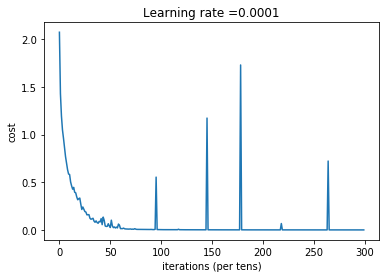

Parameters have been trained
train accu: 1.0
test accu: 0.883333


In [13]:
parameters = model(X_train, Y_train, X_test, Y_test)

In [33]:
import scipy 
from PIL import Image
from scipy import ndimage

my_image = "finger2.jpg"
fname = my_image
my_image = np.array(ndimage.imread(fname,flatten = False))
image = scipy.misc.imresize(
    my_image,size =(64,64)).reshape((1,64*64*3)).T
my_image_prediction = predict(my_image,parameters)

plt.imshow(image)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


TypeError: Input 'b' of 'MatMul' Op has type uint8 that does not match type float32 of argument 'a'.

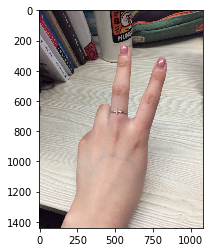

In [34]:
plt.imshow(my_image)